## Importing Libraries

In [1]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Loading Dataset

In [2]:
dataset = pd.read_csv('../Data/Timedf.csv')
dataset =dataset.dropna()
dataset.reset_index(inplace = True, drop=True)
dataset = dataset.drop(columns="Unnamed: 0")
dataset

,temp,dew,humidity,windspeed,sealevelpressure,moonphase,Year,Month,Date_split,winddir
0,27.5,10.0,36.87,14.8,1007.2,0.88,2008,4,1,200.0
1,26.2,8.9,34.64,25.9,1007.6,0.88,2008,4,1,247.5
2,25.5,12.7,46.64,25.9,1007.7,0.88,2008,4,1,129.6
3,24.4,13.8,55.26,7.6,1009.4,0.88,2008,4,1,271.3
4,26.2,21.1,74.45,11.2,1010.6,0.88,2008,4,1,236.7
...,...,...,...,...,...,...,...,...,...,...
12519,28.7,26.1,86.38,19.4,1006.1,0.69,2021,6,30,165.5
12520,37.7,19.5,36.84,27.7,997.1,0.69,2021,6,30,240.9
12521,28.4,24.6,80.19,16.6,997.2,0.69,2021,6,30,130.9
12522,26.2,22.1,79.06,5.4,1006.2,0.69,2021,6,30,270.0


### Scaling Dataset

In [3]:
f_in = dataset.columns.tolist()
# f_out = ["cgroupmemory", "cgroupcpu", "s_used_mem", "s_used_workers", "s_used_cpu", "t_assigned_cpu", "t_assigned_mem"]
f_out = ['temp']

S_in = [MinMaxScaler() for i in range(15)]

DF = pd.DataFrame(columns = dataset.columns.tolist(),index = dataset.index)
for i in range(len(DF.columns)):
  # print(dataset[dataset.columns[i]])
    col =  dataset[dataset.columns[i]]
    scaled_col = S_in[i].fit_transform(np.array(col).reshape(-1,1))
    DF[dataset.columns[i]] = scaled_col
  # DF[DF.columns[i]] = S_in[i].fit_transform(np.array(dataset[dataset.columns[i]]).reshape(-1,1))

S_o = [S_in[f_in.index(c)] for c in f_out]

In [4]:
def inv_scale(arr):
    unscaled = np.zeros(arr.shape)
    for obs in range(len(arr)):
        for i in range(1):
            unscaled[obs,:] = S_o[0].inverse_transform(arr[obs,:]) 
  
    return unscaled

### Converting Tabular Data to Time Series Data

In [5]:
X = DF.copy()
y = DF.copy()[f_out]

LOOKBACK = 365
FORECAST_WINDOW = 15

def split_sequence(sequence1, sequence2, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence1)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence1):
            break
        seq_x, seq_y = sequence1[i:lag_end], sequence2[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_ss,y_ss = split_sequence(X,y,LOOKBACK,FORECAST_WINDOW)

In [6]:
X_train = X_ss[:int(0.80*X_ss.shape[0])]
X_test = X_ss[int(0.80*X_ss.shape[0]):]
y_train = y_ss[:int(0.80*y_ss.shape[0])]
y_test = y_ss[int(0.80*y_ss.shape[0]):]

In [7]:
X_train.shape

(9716, 365, 10)

In [8]:
y_train.shape

(9716, 15, 1)

In [9]:
y_test.shape

(2429, 15, 1)

### LSTM Model Desigining

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(100,input_shape=(LOOKBACK, 10),return_sequences=True))
model.add(tf.keras.layers.LSTM(100,return_sequences=True))
model.add(tf.keras.layers.LSTM(50,return_sequences=False))
model.add(tf.keras.layers.Dense(50))
model.add(tf.keras.layers.Dense(15))
model.add(tf.keras.layers.Reshape((15,1)))


model.summary()

2022-11-22 06:26:03.223820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 1, name: Quadro P400, pci bus id: 0000:3b:00.0, compute capability: 6.1) with core count: 2. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2022-11-22 06:26:03.224145: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 06:26:03.704753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14976 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:af:00.0, compute capability: 6.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 100)          44400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 365, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                765       
_________________________________________________________________
reshape (Reshape)            (None, 15, 1)             0         
Total params: 158,315
Trainable params: 158,315
Non-trainable params: 0
__________________________________________________

In [11]:
model.compile(optimizer= tf.keras.optimizers.Adam(),  loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

### Model Trainng

In [12]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001)
callbacks = [es ,lr_red]

history = model.fit(X_train, y_train, epochs=50, batch_size=100,verbose=1,shuffle=False, validation_data=(X_test, y_test), callbacks = callbacks)
# history = model.fit(X_train, y_train, epochs=1, batch_size=100,verbose=1,shuffle=False, validation_data=(X_test, y_test))

2022-11-22 06:26:04.523357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-22 06:26:07.233770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


98/98 [==============================] - 11s 74ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - mean_absolute_error: 0.1441 - mean_squared_error: 0.0343 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1648 - val_mean_absolute_error: 0.1308 - val_mean_squared_error: 0.0272
Epoch 2/50
98/98 [==============================] - 6s 63ms/step - loss: 0.0245 - root_mean_squared_error: 0.1566 - mean_absolute_error: 0.1241 - mean_squared_error: 0.0245 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1596 - val_mean_absolute_error: 0.1263 - val_mean_squared_error: 0.0255
Epoch 3/50
98/98 [==============================] - 6s 63ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - mean_absolute_error: 0.1215 - mean_squared_error: 0.0235 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1395 - val_mean_absolute_error: 0.1078 - val_mean_squared_error: 0.0194
Epoch 4/50
98/98 [==============================] - 6s 62ms/step - loss: 0.0205 - root_mean_squared_error: 0.1430 - mea

In [13]:
model.save('../Models/s_e10_h365_p15_s')

2022-11-22 06:29:03.197643: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../Models/s_e10_h365_p15_s/assets


INFO:tensorflow:Assets written to: ../Models/s_e10_h365_p15_s/assets


In [14]:
y_pred = model.predict(X_test)

In [15]:
y_pred.shape

(2429, 15, 1)

In [16]:
y_pred_us = inv_scale(y_pred)
y_test_us = inv_scale(y_test)

### Getting Prediction vs Ground-Truth Plots

In [20]:
def plot_line(i):
    plt.plot(y_test_us[:,i], label = "Ground Truth")
    plt.plot(y_pred_us[:,i], label = "Predicted")
    # plt.ylim(bottom=0)
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Temprature")
    plt.savefig('actual vs predicted.png')
    plt.show()

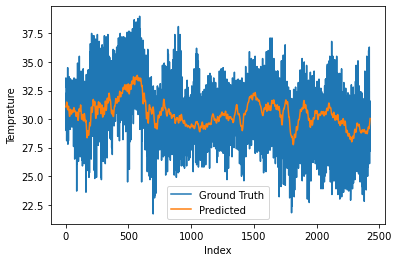

In [21]:
plot_line(3)



### Plotting Trinaing Performance of LSTM Model

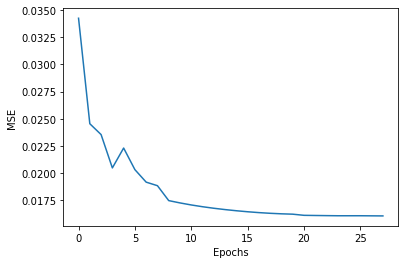

In [19]:
plt.plot(history.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig('MSE History.png')